Module 5: Basics

In [1]:
import pandas as pd
import json
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer #not needed as TfidfVectorizer is being used.
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [2]:
jepordarydf = pd.read_json('jeopardy.json')

In [3]:
jepordarydf.head(2)

,category,air_date,question,value,answer,round,show_number
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",$200,Copernicus,Jeopardy!,4680
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,$200,Jim Thorpe,Jeopardy!,4680


In [4]:
#investigating what rounds are present in the dataset
jepordarydf['round'].unique()

array(['Jeopardy!', 'Double Jeopardy!', 'Final Jeopardy!', 'Tiebreaker'],
      dtype=object)

Preprocessing the Data

In [5]:
#tokenizing the 'question' column of the jeopardy dataset.
questiontoken = jepordarydf['question'].apply(word_tokenize)
#taking a look at the newly tokenized questions
questiontoken.head(2)

,question
0,"['For, the, last, 8, years, of, his, life, ,, ..."
1,"['No, ., 2, :, 1912, Olympian, ;, football, st..."


In [6]:
#defining stopwords to drop commonly used words from the question column.
english_stopwords = stopwords.words('english') + list(punctuation) + ["'", '``', ',']

In [7]:
#creating a list of questions without the stopwords
stopped_questions = [x for x in questiontoken if not x in english_stopwords]

#stopped_questions

In [8]:
#trying to set up parts of speech for lemmization
#pos_tagged = [pos_tag(word_tokenize(sent)) for sent in sent_tokenize(jepordarydf['question'])]
#the previous line of code didn't work as it was not expecting a series, tried to then use the apply function to set up the pos
pos_tagged = questiontoken.apply(pos_tag)

In [9]:
#checking it was applied correctly
pos_tagged.head(2)

,question
0,"[('For, ''), (the, DT), (last, JJ), (8, CD), (..."
1,"[('No, POS), (., .), (2, CD), (:, :), (1912, C..."


In [10]:
#attempt to set up the lemmatizer
lemmatizer = WordNetLemmatizer()
#did not work as expected as it again did not expect a series
#lematized = [lemmatizer.lemmatize(eachword) for eachword in word_tokenize(questiontoken)]
#attempted to use the apply function again using lambda
lematized = questiontoken.apply(lambda eachword: [lemmatizer.lemmatize(word) for word in eachword])

In [11]:
lematized.head(2)
#the lemmatization did not quite work as expected as seen in the second row. While it worked well for the first, puncuation appeared to interfere.

,question
0,"['For, the, last, 8, year, of, his, life, ,, G..."
1,"['No, ., 2, :, 1912, Olympian, ;, football, st..."


In [12]:
#checking for any null values in the df, as these would be disastrous for predictions.
print(jepordarydf.shape)
jepordarydf.isnull().sum()
#the dataset has 3634 null values in the 'value' column which will be cleaned next.

(216930, 7)


,0
category,0
air_date,0
question,0
value,3634
answer,0
round,0
show_number,0


In [13]:
#dropping rows with missing values so it doesn't affect the classifier later.
jepordarydf = jepordarydf.dropna()
jepordarydf.isnull().sum()

,0
category,0
air_date,0
question,0
value,0
answer,0
round,0
show_number,0


In [14]:
#examining where the null values were located. leaving the jeopardy and double jeopardy categories.
jepordarydf['round'].unique()

array(['Jeopardy!', 'Double Jeopardy!'], dtype=object)

In [15]:
#stripping the 'vallue' column of its dollarsigns and commas and making it an 'int' type so I can turn it into a binary value later.
jepordarydf['value']=(jepordarydf['value'].str.replace('$', '').str.replace(',','').astype(int))

In [16]:
#setting the binary value with 1 being high value and 0 being low value
jepordarydf['valuebinary'] = jepordarydf['value'].apply(lambda x: 1 if x > 1000 else 0)

In [17]:
jepordarydf.head(2)

,category,air_date,question,value,answer,round,show_number,valuebinary
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",200,Copernicus,Jeopardy!,4680,0
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,200,Jim Thorpe,Jeopardy!,4680,0


In [18]:
#examining the value counts of the new binary column to see how the data is distributed thus far.
jepordarydf['valuebinary'].value_counts()

,count
valuebinary,
0,173628
1,39668


In [19]:
#upon creating the 'valuebinary' column, I noticed that higher tier rounds like double and final jeopardy typically contain questions with higher difficulty.
#thus setting a target above or below a certain desired value may not correctly categorize the correct difficulty for a question.
def settingvalue(number):
  value = number['value']
  rounds = number['round']
#defining a high value for the jeopardy round as any value above $600
  if rounds == 'Jeopardy!':
    if value > 600:
      return 1
    else:
      return 0
  #defining a high value for the double jeopardy round as any value above $1000
  elif rounds == 'Double Jeopardy!':
    if value > 1000:
      return 1
    else:
      return 0
  #NOTE: I didn't include other categories like final jeopardy or tiebreaker as these were rows that had to be dropped as it contained null values that would have otherwise inferred with the model predictions.

In [20]:
#updating the valuebinary column since categories like double and final jeopardy have a higher starting difficulty than normal jeopardy.
jepordarydf['valuebinary'] = jepordarydf.apply(settingvalue, axis=1)

In [21]:
#checking the updated value counts, it is a tad better but not much.
jepordarydf['valuebinary'].value_counts()

,count
valuebinary,
0,148705
1,64591


Creating Training and Testing Sets

In [23]:
#here, im defining 'X' and 'y' as the columns I want to use in the classifier.
#I set 'X' as question and 'y' as the valuebinary as I want to make a classifier that looks at the probability of a question being easy or hard based on the binary value.
X = jepordarydf['question']
y = jepordarydf['valuebinary']

In [24]:
#defining tf as TfidfVectorizer() to avoid getting errors.
tf = TfidfVectorizer()
#splitting the training and testing set with the previously defined 'X' and 'y'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
#getting trained set based on training data vectors
X_train_tf = tf.fit_transform(X_train)

X_test_tf = tf.transform(X_test)

Model Creation

In [25]:
#creating the model
model=MultinomialNB()
#fitting the model using the training data
model.fit(X_train_tf, y_train)
predictions = model.predict(X_test_tf)

Model Accurracy

In [26]:
print('Accuracy: ', accuracy_score(y_test, predictions))

Accuracy:  0.7027979896481884


Based on the accuracy score, I could assume that the model is accurate about 70% of the times at the current moment. However, it remains to be seen how truely accurate the model truly is.

**Confusion Matrix**

Here, I am attempting to construct a confusion matrix to evaluate the preformance of the model beyond the accuracy, I previously found.

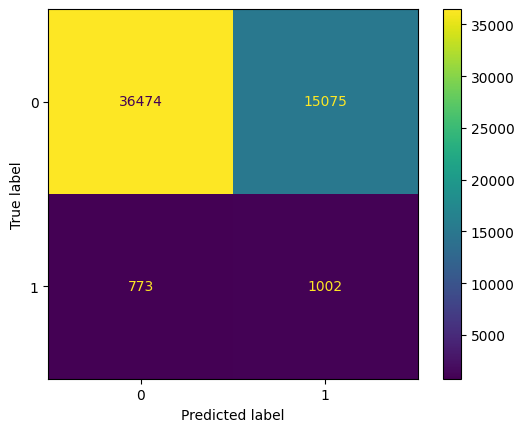

In [27]:
#creating a confusion matrix using the predictions and y_test data
CFM = confusion_matrix(predictions, y_test)
#plotting the confusion matrix
cfmdis = ConfusionMatrixDisplay(confusion_matrix=CFM)
cfmdis.plot()
plt.show()

False Negative Exploration

In [28]:
false_neg = round(CFM[0,1]/(CFM[0,1]+CFM[1,1]),6)
print('False Negative Rate:', false_neg)

False Negative Rate: 0.937675


While the initial accuracy score seemed to be encouraging, upon further exploration of the false negative rate shows that the model is highly likely to wrongly predict whether or not a question is hard based on its value binary level. Perhaps, another model would handle this data better, or the false positive rate could be due to the size and difficulty of this dataset.